In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/'
CURR_DIR += '3_semantic_segmentation/'
sys.path.append(CURR_DIR)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [12]:
import os.path
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
print('torch.__version__ =', torch.__version__)

from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

torch.__version__ = 1.6.0+cu101


In [3]:
def MakeDatapathList(root_path):
    img_path_template = os.path.join(root_path, 'JPEGImages', '%s.jpg')
    anno_path_template = os.path.join(root_path, 'SegmentationClass', '%s.png')

    train_id_names = os.path.join(root_path + 'ImageSets/Segmentation/train.txt')
    val_id_names = os.path.join(root_path + 'ImageSets/Segmentation/val.txt')

    train_img_list = []
    train_anno_list = []
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (img_path_template % file_id)
        anno_path = (anno_path_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    val_img_list = []
    val_anno_list = []
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (img_path_template % file_id)
        anno_path = (anno_path_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [5]:
root_path = CURR_DIR + 'data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = MakeDatapathList(root_path)

print(train_img_list[0])
print(train_anno_list[0])

/content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/3_semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
/content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/3_semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


In [6]:
class DataTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),
                RandomRotation(angle=[-10, 10]), # [deg]
                RandomMirror(),
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std) ### PIL(h, w, c) ---> Torch(c, h, w)
            ]),
            'val': Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ])
        }


    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](img, anno_class_img)

In [9]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, anno_list, phase, data_transform):
        assert len(img_list) == len(anno_list)
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.data_transform = data_transform

    
    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, idx):
        img, anno_class_img = self.RetrieveItem(idx)
        return img, anno_class_img 


    def RetrieveItem(self, idx):
        img_file_path = self.img_list[idx]
        img = PIL.Image.open(img_file_path) ### (h, w, c=RGB)

        anno_file_path = self.anno_list[idx]
        anno_class_img = PIL.Image.open(anno_file_path) ### (h, w)

        img, anno_class_img = self.data_transform(self.phase, img, anno_class_img)
        return img, anno_class_img 

In [21]:
input_size = 475
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

data_transform = DataTransform(input_size, color_mean, color_std)

train_dataset = VOCDataset(train_img_list, train_anno_list, 'train', data_transform)
val_dataset = VOCDataset(val_img_list, val_anno_list, 'val', data_transform)

idx = 0
img, anno_class_img = val_dataset.__getitem__(idx)
print()
print('img.size() =', img.size())
print('anno_class_img.size() =', anno_class_img.size())
print()


img.size() = torch.Size([3, 475, 475])
anno_class_img.size() = torch.Size([475, 475])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



img_np.shape = (475, 475, 3)



<function matplotlib.pyplot.show>

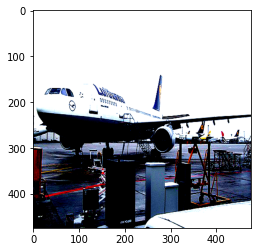

In [24]:
img_np = img.numpy().transpose((1, 2, 0)) ### Torch(c, h, w) ---> Numpy(h, w, c)

print()
print('img_np.shape =', img_np.shape)
print()

plt.imshow(img_np)
plt.show


anno_class_img_pil.size = (475, 475)



<function matplotlib.pyplot.show>

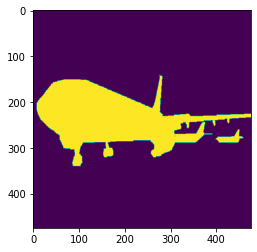

In [25]:
### Get color palette info from annotated image
anno_file_path = val_anno_list[idx]
p_palette = PIL.Image.open(anno_file_path).getpalette()

anno_class_img_np = anno_class_img.numpy() ### Torch(h, w) ---> Numpy(h, w)
anno_class_img_pil = PIL.Image.fromarray(np.uint8(anno_class_img_np), mode='P') ### Numpy(h, w) ---> PIL(h, w)
anno_class_img_pil.putpalette(p_palette)

print()
print('anno_class_img_pil.size =', anno_class_img_pil.size)
print()

plt.imshow(anno_class_img_np)
plt.show

In [26]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader,
}

val_batch_iter = iter(dataloaders_dict['val'])
imgs, anno_class_imgs = next(val_batch_iter)

print('imgs.size() =', imgs.size()) ### (n, c, h, w)
print('anno_class_imgs.size() =', anno_class_imgs.size()) ### (n, h, w)

imgs.size() = torch.Size([8, 3, 475, 475])
anno_class_imgs.size() = torch.Size([8, 475, 475])
